# 3. Модель сегментации текста 

In [1]:
import os
import sys
import random
import itertools
import pickle
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from pandarallel import pandarallel

import pymorphy2
import nltk

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from keras.preprocessing.sequence import pad_sequences

sys.path.append("..")
from src import *

def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True
init_random_seed()
    
pd.set_option('display.max_colwidth', 255)
tqdm.pandas()
pandarallel.initialize(progress_bar=True, nb_workers=8, use_memory_fs=False)

%load_ext autoreload
%autoreload 2

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## 1. Загрузка данных

In [5]:
abbr = pd.read_csv("../data/abbr.csv")
lenta_train = pd.read_csv("../data/lenta_train.csv")
lenta_test = pd.read_csv("../data/lenta_test.csv")

In [6]:
lenta_train["labels_new"] = (
    lenta_train["labels_new"].str.replace("W", "")
                            .str.replace("B", "")
                            .str.replace("E", "")
                            .str.replace("-", "")
)
train_texts = list(map(lambda x: x.split(" "), lenta_train["text_new"].to_list()))
train_labels = list(map(lambda x: x.split(" "), lenta_train["labels_new"].to_list()))

lenta_test["labels_new"] = (
    lenta_test["labels_new"].str.replace("W", "")
                            .str.replace("B", "")
                            .str.replace("E", "")
                            .str.replace("-", "")
)
test_texts = list(map(lambda x: x.split(" "), lenta_test["text_new"].to_list()))
test_labels = list(map(lambda x: x.split(" "), lenta_test["labels_new"].to_list()))

## 2. Сборка датасета

In [7]:
PAD_TOKEN = "<PAD>"
PAD_TOKEN_ID = 0

PAD_LABEL = "<NOLABEL>"
PAD_LABEL_ID = 0

EMPTY_LABEL = "_"
EMPTY_LABEL_ID = 1

train_texts_global = list(itertools.chain(*train_texts))
train_labels_global = list(itertools.chain(*train_labels))
train_labels_global = list(filter(lambda x: x != EMPTY_LABEL, train_labels_global))

UNIQUE_TOKENS = [PAD_TOKEN] + list(set(train_texts_global))
UNIQUE_LABELS = [PAD_LABEL, EMPTY_LABEL] + list(set(train_labels_global))

token2id = {label: i for i, label in enumerate(UNIQUE_TOKENS)}
id2token = {i: label for label, i in token2id.items()}

label2id = {label: i for i, label in enumerate(UNIQUE_LABELS)}
id2label = {i: label for label, i in label2id.items()}

MAX_SENTENCE_LEN = lenta_train.text_new.str.split(" ").str.len().max()
train_size = len(train_texts)
test_size = len(test_texts)
TOKENS_NUM = len(UNIQUE_TOKENS)
LABELS_NUM = len(UNIQUE_LABELS)

print(MAX_SENTENCE_LEN, train_size, test_size, TOKENS_NUM, LABELS_NUM)

280 548700 137175 587151 1275


In [8]:
def get_tensor_dataset(sentences, labels, token2id, label2id, max_sent_len):
    sent_num = len(sentences)
    
    inputs = torch.zeros((sent_num, max_sent_len), dtype=torch.long)
    targets = torch.zeros((sent_num, max_sent_len), dtype=torch.long)
    
    for text_i, text in tqdm(enumerate(sentences)):
        text = text[:max_sent_len]
        for token_i, token in enumerate(text):
            label = labels[text_i][token_i]
            inputs[text_i, token_i] = token2id.get(token, 0)
            targets[text_i, token_i] = label2id.get(label, 0)
            
    return TensorDataset(inputs, targets)

In [2]:
# train_dataset = get_tensor_dataset(sentences=train_texts, 
#                                    labels=train_labels, 
#                                    token2id=token2id, 
#                                    label2id=label2id, 
#                                    max_sent_len=MAX_SENTENCE_LEN)

# test_dataset = get_tensor_dataset(sentences=test_texts, 
#                                    labels=test_labels, 
#                                    token2id=token2id, 
#                                    label2id=label2id, 
#                                    max_sent_len=MAX_SENTENCE_LEN)

# torch.save(train_dataset, "../data/train_dataset.tensor_dataset")
# torch.save(test_dataset, "../data/test_dataset.tensor_dataset")

train_dataset = torch.load("../data/train_dataset.tensor_dataset")
test_dataset = torch.load("../data/test_dataset.tensor_dataset")

## 3. Архитектура

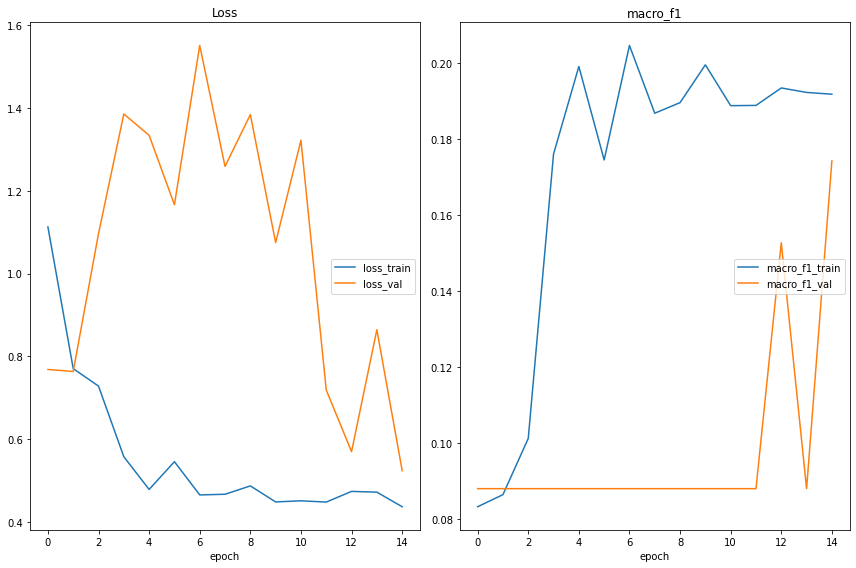

Loss
	loss_train       	 (min:    0.437, max:    1.113, cur:    0.437)
	loss_val         	 (min:    0.525, max:    1.551, cur:    0.525)
macro_f1
	macro_f1_train   	 (min:    0.083, max:    0.205, cur:    0.192)
	macro_f1_val     	 (min:    0.088, max:    0.174, cur:    0.174)
Досрочно остановлено пользователем


In [13]:
BATCH_SIZE = 4

embedding_size = 4
num_layers = MAX_SENTENCE_LEN
dropout = 0.2
bidirectional = False

model = NnClassifier(
    tokens_num=TOKENS_NUM, 
    labels_num=LABELS_NUM, 
    embedding_size=embedding_size, 
    backbone=RnnNet,
    input_size=embedding_size,
    hidden_size=embedding_size, 
    num_layers=num_layers, 
    batch_first=True,
    dropout=dropout,
    bidirectional=bidirectional
)
params = get_model_params_num(model)

model_name = create_model_name(
    model="RnnNet", 
    emb=embedding_size, 
    num_layers=num_layers, 
    dropout=dropout,
    bidirectional=bidirectional,
    params=params
)
print(model_name)

learner = TorchLearner(
    model=model, 
    loss_function=F.cross_entropy, 
    train_dataset=train_dataset, 
    val_dataset=test_dataset, 
    metrics={"macro_f1": get_f1_score}, 
    optimizer=optim.Adam, 
    batch_size=BATCH_SIZE, 
    device="cuda",
    lr=1e-1
)

learner.fit(
    epoch=1000, 
    step_per_epoch_train=100, 
    step_per_epoch_val=50, 
    early_stopping_patience=10
)

torch.save(learner.best_model.state_dict(), os.path.join("../models/", model_name + ".model"))

with open(os.path.join("../logs/", model_name + ".log"), "w") as f:
    json.dump(learner.history, f)

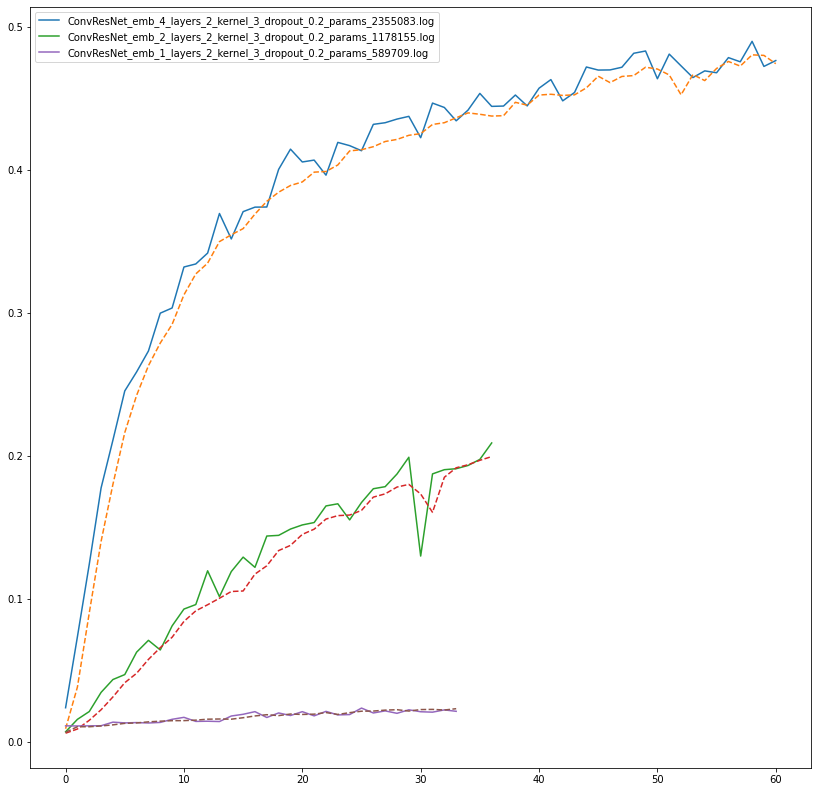

In [77]:
plt.figure(figsize=(14, 14))
for model_name in os.listdir("../logs"):
    with open(os.path.join("../logs", model_name)) as f:
        history = json.load(f)
    plt.plot(history["epoch"], history["macro_f1_val"], label=model_name)
    plt.plot(history["epoch"], history["macro_f1_train"], "--")
plt.legend()